In [1]:
# Importação das Bibliotecas que serão utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  

2023-05-23 00:16:46.388996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 00:16:46.606294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 00:16:46.606322: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-23 00:16:47.741027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Caminho relativo para os dados
path_cadastral     = 'data/base_cadastral.csv'
path_info          = 'data/base_info.csv'
path_pagament_dev  = 'data/base_pagamentos_desenvolvimento.csv'
path_pagament_test = 'data/base_pagamentos_teste.csv'

### Base Cadastral

In [3]:
base_cadastral = pd.read_csv(path_cadastral)
base_cadastral.head()

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,NaN,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,NaN,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,NaN,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,NaN,Serviços,GMAIL,GRANDE,62


In [4]:
base_cadastral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_CLIENTE           1315 non-null   int64 
 1   DATA_CADASTRO        1315 non-null   object
 2   DDD                  1078 non-null   object
 3   FLAG_PF              66 non-null     object
 4   SEGMENTO_INDUSTRIAL  1232 non-null   object
 5   DOMINIO_EMAIL        1285 non-null   object
 6   PORTE                1274 non-null   object
 7   CEP_2_DIG            1315 non-null   object
dtypes: int64(1), object(7)
memory usage: 82.3+ KB


In [5]:
base_cadastral['ANO_CADASTRO'] = base_cadastral['DATA_CADASTRO'].str[:4]

In [6]:
def grafico_distribuicao(titulo,coluna):
    plt.title(titulo)
    base_cadastral[coluna].value_counts().plot.bar()
    plt.show()

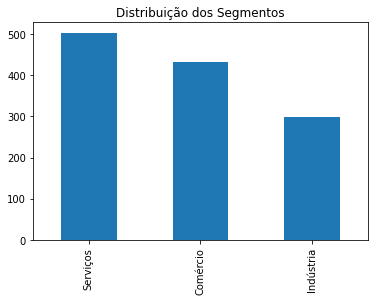

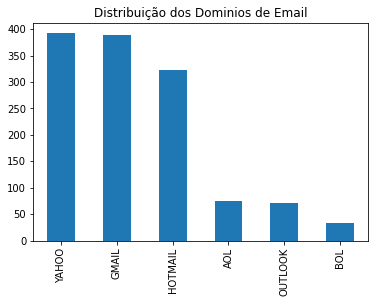

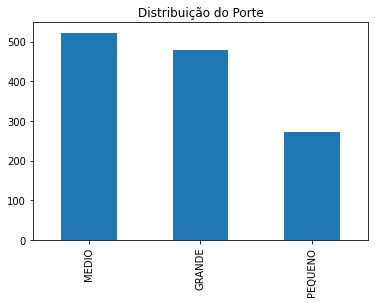

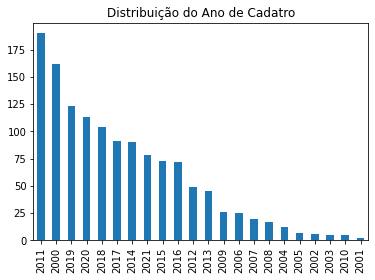

In [7]:
titulos = ['Distribuição dos Segmentos','Distribuição dos Dominios de Email','Distribuição do Porte','Distribuição do Ano de Cadatro']
colunas = ['SEGMENTO_INDUSTRIAL','DOMINIO_EMAIL','PORTE','ANO_CADASTRO']

for titulo,coluna in zip(titulos,colunas):
    grafico_distribuicao(titulo,coluna)

In [8]:
# Tratamento da coluna DDD e os 10 maiores DDD's com preenchimento
base_cadastral['DDD'] = base_cadastral['DDD'].str.replace('(','9') # Tratei a '(' pois normalmente ela está vinculada com o numero 9 no teclado
base_cadastral['DDD'].value_counts().head(10)

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


11    125
91     70
19     50
21     39
41     37
31     33
62     31
51     28
47     25
65     23
Name: DDD, dtype: int64

In [9]:
# Analisando qual volumetria com preenchimento
base_cadastral['FLAG_PF'].fillna('sem info').value_counts()

sem info    1249
X             66
Name: FLAG_PF, dtype: int64

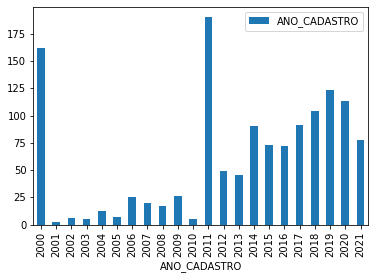

In [10]:
# Cadastros de maneira ordenada, podemos observar que a partir de 2011 tivemos maiores numeros de cadastros tirando a excessão de 2000
base_cadastral.groupby(['ANO_CADASTRO'])[['ANO_CADASTRO']].count().plot.bar()
plt.show()

In [11]:
# Distribuição dos CEPS
base_cadastral['CEP_2_DIG'].value_counts().head(10)

13    86
78    60
89    44
68    42
29    40
37    33
88    28
38    26
14    26
86    25
Name: CEP_2_DIG, dtype: int64

In [12]:
# Tratamento de Dados
base_cadastral['DDD']    = base_cadastral['DDD'].fillna(-1).astype(int)
base_cadastral['FLAG_PF'] = np.where(~base_cadastral['FLAG_PF'].isnull(),1,-1)
base_cadastral['SEGMENTO_INDUSTRIAL'] = base_cadastral['SEGMENTO_INDUSTRIAL'].fillna(-1).astype('category').cat.codes 
base_cadastral['DOMINIO_EMAIL'] = base_cadastral['DOMINIO_EMAIL'].fillna(-1).astype('category').cat.codes
base_cadastral['PORTE'] = base_cadastral['PORTE'].fillna(-1).astype('category').cat.codes
base_cadastral['CEP_2_DIG'] = base_cadastral['CEP_2_DIG'].replace('na',np.nan).fillna(-1).astype(int)

### Base Informações

In [13]:
base_info = pd.read_csv(path_info)
base_info.head()

,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,92.0
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0
3,1003144834589372198,2018-09,239659.0,96.0
4,324916756972236008,2018-09,203123.0,103.0


In [14]:
base_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_CLIENTE          24401 non-null  int64  
 1   SAFRA_REF           24401 non-null  object 
 2   RENDA_MES_ANTERIOR  24401 non-null  float64
 3   NO_FUNCIONARIOS     24401 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 762.7+ KB


In [15]:
base_info.groupby(['SAFRA_REF'])['NO_FUNCIONARIOS'].mean().head(10)

SAFRA_REF
2018-09    106.659134
2018-10    106.399293
2018-11    106.550542
2018-12    106.257549
2019-01    112.332136
2019-02    113.317291
2019-03    113.526221
2019-04    112.585841
2019-05    112.698774
2019-06    113.625659
Name: NO_FUNCIONARIOS, dtype: float64

In [16]:
base_info.groupby(['SAFRA_REF'])['RENDA_MES_ANTERIOR'].mean().head(10)

SAFRA_REF
2018-09    274010.983051
2018-10    277700.484099
2018-11    288293.393502
2018-12    298405.083481
2019-01    275867.515260
2019-02    286771.721925
2019-03    286972.166365
2019-04    293964.706195
2019-05    290033.287215
2019-06    284328.794376
Name: RENDA_MES_ANTERIOR, dtype: float64

### Base Pagamentos

In [17]:
base_pagamentos_dev = pd.read_csv(path_pagament_dev)
base_pagamentos_dev.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99


In [18]:
base_pagamentos_dev['QTD_DIAS_EMISSAO_VENCIMENTO'] = (pd.to_datetime(base_pagamentos_dev['DATA_VENCIMENTO']) - pd.to_datetime(base_pagamentos_dev['DATA_EMISSAO_DOCUMENTO'])).dt.days

In [19]:
base_pagamentos_dev['DIAS_ATRASO'] = (pd.to_datetime(base_pagamentos_dev['DATA_PAGAMENTO']) - pd.to_datetime(base_pagamentos_dev['DATA_VENCIMENTO'])).dt.days

In [20]:
base_pagamentos_dev['DIAS_ATRASO'].value_counts().head(10)

 0    60742
-1     2841
 1     1898
 5      955
-3      815
 7      718
 6      700
 2      602
-2      583
 3      525
Name: DIAS_ATRASO, dtype: int64

In [1]:
base_pagamentos_dev['TARGET'] = np.where(base_pagamentos_dev['DIAS_ATRASO']>=5,1,0)

NameError: name 'np' is not defined

In [22]:
base_pagamentos_dev['TARGET'].value_counts(normalize=True)

0    0.92978
1    0.07022
Name: TARGET, dtype: float64

### Cruzamento Das Bases

In [23]:
base_final_dev = pd.merge(base_cadastral,base_pagamentos_dev,how='inner',on=['ID_CLIENTE'])

In [24]:
base_final_dev

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,ANO_CADASTRO,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,QTD_DIAS_EMISSAO_VENCIMENTO,DIAS_ATRASO,TARGET
0,1661240395903230676,2013-08-22,99,-1,3,6,3,65,2013,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,20,0,0
1,1661240395903230676,2013-08-22,99,-1,3,6,3,65,2013,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,22,1,0
2,1661240395903230676,2013-08-22,99,-1,3,6,3,65,2013,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,22,1,0
3,1661240395903230676,2013-08-22,99,-1,3,6,3,65,2013,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,36,6,1
4,1661240395903230676,2013-08-22,99,-1,3,6,3,65,2013,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77409,2694466161223698243,2021-06-23,98,-1,1,6,3,54,2021,2021-06,2021-06-22,2021-07-21,2021-07-15,3636.81,5.99,23,6,1
77410,4166581859919473627,2017-08-06,-1,-1,1,4,2,30,2017,2021-06,2021-06-27,2021-07-12,2021-07-12,188830.88,6.99,15,0,0
77411,4235078665660987689,2017-09-14,11,-1,3,3,1,66,2017,2021-06,2021-06-27,2021-07-15,2021-07-13,109011.35,4.99,16,2,0
77412,7628167057144760589,2021-05-05,91,-1,1,3,3,14,2021,2021-06,2021-06-29,2021-07-15,2021-07-15,180770.00,11.99,16,0,0


In [25]:
base_final_dev.dtypes

ID_CLIENTE                       int64
DATA_CADASTRO                   object
DDD                              int64
FLAG_PF                          int64
SEGMENTO_INDUSTRIAL               int8
DOMINIO_EMAIL                     int8
PORTE                             int8
CEP_2_DIG                        int64
ANO_CADASTRO                    object
SAFRA_REF                       object
DATA_EMISSAO_DOCUMENTO          object
DATA_PAGAMENTO                  object
DATA_VENCIMENTO                 object
VALOR_A_PAGAR                  float64
TAXA                           float64
QTD_DIAS_EMISSAO_VENCIMENTO      int64
DIAS_ATRASO                      int64
TARGET                           int64
dtype: object

In [26]:
base_final_dev = base_final_dev.merge(base_info,how='inner',on=['ID_CLIENTE','SAFRA_REF'])

In [27]:
colsModelo = ['DDD','SEGMENTO_INDUSTRIAL','DOMINIO_EMAIL','PORTE','CEP_2_DIG','VALOR_A_PAGAR','TAXA','QTD_DIAS_EMISSAO_VENCIMENTO','RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']

### Treinando o Modelo

In [28]:
X = base_final_dev[colsModelo]
y = base_final_dev['TARGET']

In [29]:
# Dividindo os Dados de Desenvolvimento em Treino e Teste para poder efetuar a criação do modelo e testar seu desempenho
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.70,random_state=10)

In [30]:
# Para verificar como está a distribuição de treino e teste em cada Base
y_train.value_counts(normalize=True),y_test.value_counts(normalize=True)

(0    0.929229
 1    0.070771
 Name: TARGET, dtype: float64,
 0    0.930843
 1    0.069157
 Name: TARGET, dtype: float64)

In [31]:
# Definindo o modelo que será utilizado
clf = RandomForestClassifier(n_estimators = 100)  
# Treinando o modelo com os dados de Treino
clf.fit(X_train, y_train)
# Aplicando o modelo nos Dados de Teste
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
# Analisando como está a Acuracia do modelo nos dados de Treino  
#print("Acuracia do Modelo Treino: ", metrics.accuracy_score(y_train, y_pred_train))
# Analisando como está a Acuracia do modelo nos dados de Teste 
print("Acuracia do Modelo Teste: ", metrics.accuracy_score(y_test, y_pred))

Acuracia do Modelo Teste:  0.9535910098378505


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


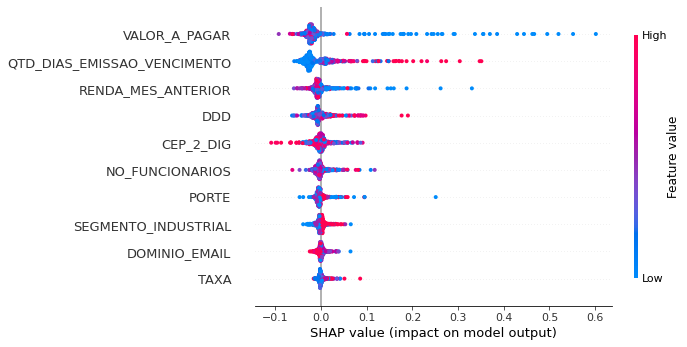

In [32]:
# Shap onde é apresentado as variaveis mais importante para o modelo
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test[:500])
shap.summary_plot(shap_values[1], X_test[:500])

In [33]:
# Aplicando o Modelo na base de Treino
base_final_dev['INADIMPLENTE'] = clf.predict_proba(base_final_dev[colsModelo])[:,1]

In [34]:
# Salvando a Base com as colunas solicitadas para Treino
path_dev_inadimplente = 'data/base_dev_cliente_inadimplente.csv'
base_final_dev[['ID_CLIENTE', 'SAFRA_REF','INADIMPLENTE']].to_csv(path_dev_inadimplente,index=False)

### Aplicando na base de Teste

In [35]:
base_pagamentos_test = pd.read_csv(path_pagament_test)

In [36]:
base_pagamentos_test['QTD_DIAS_EMISSAO_VENCIMENTO'] = (pd.to_datetime(base_pagamentos_test['DATA_VENCIMENTO']) - pd.to_datetime(base_pagamentos_test['DATA_EMISSAO_DOCUMENTO'])).dt.days

In [37]:
base_final_test = pd.merge(base_cadastral,base_pagamentos_test,how='inner',on=['ID_CLIENTE'])

In [38]:
base_final_test = base_final_test.merge(base_info,how='inner',on=['ID_CLIENTE','SAFRA_REF'])

In [39]:
# Aplicando o Modelo na base de Teste
base_final_test['INADIMPLENTE'] = clf.predict_proba(base_final_test[colsModelo])[:,1]

In [40]:
# Salvando a Base com as colunas solicitadas
path_test_inadimplente = 'data/base_teste_cliente_inadimplente.csv'
base_final_test[['ID_CLIENTE', 'SAFRA_REF','INADIMPLENTE']].to_csv(path_test_inadimplente,index=False)